# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Train ggpg agent

In [5]:
from collections import deque
import matplotlib.pyplot as plt
from ddpg_agent import Agent
import torch

%matplotlib inline

In [6]:
def ddpg(n_episodes=3500, max_t=1000):
    """ Deep Deterministic Policy Gradients
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=100)
    scores = np.zeros(num_agents)
    scores_episode = []
    
    agents =[] 
    
    # amplitude of OU noise
    # this slowly decreases to 0
    noise = 2
    noise_reduction = 0.9999
    
    for i in range(num_agents):
        agents.append(Agent(state_size, action_size, random_seed=0))
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        for agent in agents:
            agent.reset()
            
        scores = np.zeros(num_agents)
            
        t = 0    
        while True:
            #actions = [agents[i].act(states[i]) for i in range(num_agents)]
            actions = np.array([agents[i].act(states[i],noise) for i in range(num_agents)])
            noise *= noise_reduction
#             if t == 0:
#                 print("actions", actions)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done        
            
            for i in range(num_agents):
                agents[i].step(t,states[i], actions[i], rewards[i], next_states[i], dones[i]) 
 
            states = next_states
            scores += rewards
            if np.any(dones):
                break
            t += 1
            
        score = np.max(scores)
        scores_window.append(score)       # save most recent score
        scores_episode.append(score)

        #print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end="\n")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\n'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(Agent.instances[0].actor_local.state_dict(), 'checkpoint1_actor0.pth')
            torch.save(Agent.instances[1].actor_local.state_dict(), 'checkpoint1_actor1.pth')
            torch.save(Agent.critic_local.state_dict(), 'checkpoint1_critic.pth')
    
            break
            
    return scores_episode

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
    
scores = ddpg()

Initialising ReplayBuffer
Appended to Agent.instances agent 0
Appended to Agent.instances agent 1
Episode 100	Average Score: 0.02.64	Rewards [ 0.00 -0.01]	Scores: [ 0.00 -0.01]

Episode 200	Average Score: 0.07.17	Rewards [ 0.00 -0.01]	Scores: [ 0.00  0.09]]

Episode 300	Average Score: 0.10.77	Rewards [ 0.00 -0.01]	Scores: [ 0.20  0.09]]

Episode 400	Average Score: 0.12.45	Rewards [-0.01  0.00]	Scores: [-0.01  0.00]]

Episode 490	Timestep 1000	Noise 0.06	Rewards [ 0.00  0.00]	Scores: [ 2.60  2.60]
Environment solved in 390 episodes!	Average Score: 0.52


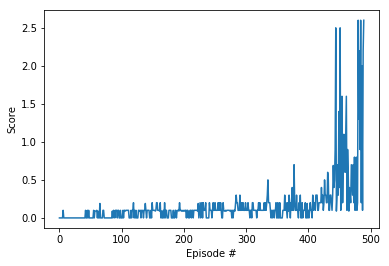

In [7]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [8]:
env.close()